In [1]:
# Create network from the two molecules
import openfe
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from openfe.setup.ligand_network_planning import generate_radial_network
from openfe.setup import LomapAtomMapper

In [2]:
supp = Chem.SDMolSupplier("000.sdf", removeHs=False)
ligands = [mol for mol in supp]

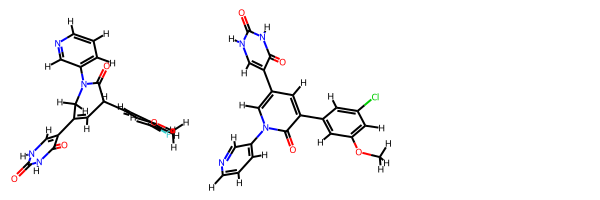

In [3]:
Chem.Draw.MolsToGridImage(ligands)

In [25]:
# Now pass these to form a list of Molecules
x = 0
#ligand_mols = [openfe.SmallMoleculeComponent(sdf, name='lig' + str(x)) for sdf in ligands]
ligand_mols = []
for sdf in ligands:
    ligand_mols.append(openfe.SmallMoleculeComponent(sdf, name='lig' + str(x)))
    x +=1


In [27]:
print("name: ", ligand_mols[0].name)

name:  lig1


In [6]:
scorer = openfe.lomap_scorers.default_lomap_score

network = generate_radial_network(ligands=ligand_mols[1:],
                                  central_ligand=ligand_mols[0],
                                  mappers=[LomapAtomMapper(threed=True, element_change=True),],
                                  scorer=scorer)

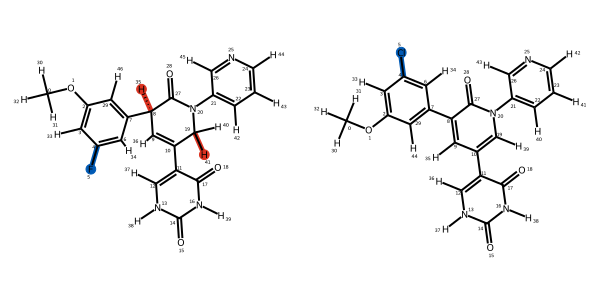

In [7]:
# Display all the atom mappings
edges = [edge for edge in network.edges]
for edge in edges:
    display(edge)

In [9]:
for mapping in network.edges:
    print(mapping.annotations)

#network.edges['mapping']

{'score': 0.7046880897187134}


In [10]:
# First let's define the Protein and Solvent Components which we will be using
from openfe import SolventComponent
from openff.units import unit

solvent = SolventComponent(positive_ion='Na', negative_ion='Cl',
                           neutralize=False, ion_concentration=0*unit.molar)

In [12]:
frag_name = edges[0].componentB.name
# Extract the relevant edge for the benzene -> phenol transform in the radial graph
parent_2_frag = [edge for edge in network.edges if edge.componentB.name == frag_name][0]
print(parent_2_frag)

LigandAtomMapping(componentA=SmallMoleculeComponent(name=), componentB=SmallMoleculeComponent(name=), componentA_to_componentB={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 42: 40, 43: 41, 44: 42, 45: 43, 46: 44}, annotations={'score': 0.7046880897187134})


In [13]:
# Let's create the four ChemicalSystems
from openfe import ChemicalSystem

parent_solvent = ChemicalSystem({'ligand': edges[0].componentA,
                                  'solvent': solvent,})

frag_solvent = ChemicalSystem({'ligand': edges[0].componentB,
                                 'solvent': solvent,})

In [14]:
#------------------- MD parameters ------------------------------
# Settings can be accessed from the various classes

from openfe.protocols.openmm_rfe.equil_rfe_settings import (
    SystemSettings, SolvationSettings, AlchemicalSettings,
    OpenMMEngineSettings, AlchemicalSamplerSettings,
    IntegratorSettings, SimulationSettings
)

system = SystemSettings(nonbonded_cutoff=1.2 * unit.nanometer)

from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol

rbfe_settings = RelativeHybridTopologyProtocol.default_settings()

from pprint import pp

In [16]:
rbfe_settings.simulation_settings.equilibration_length = 500 * unit.picosecond
rbfe_settings.simulation_settings.production_length = 2 * unit.nanosecond

pp(rbfe_settings.simulation_settings)

SimulationSettings(equilibration_length=<Quantity(500, 'picosecond')>, production_length=<Quantity(2, 'nanosecond')>, forcefield_cache='db.json', minimization_steps=5000, output_filename='simulation.nc', output_structure='hybrid_system.pdb', output_indices='not water', checkpoint_interval=<Quantity(250, 'timestep')>, checkpoint_storage='checkpoint.nc')


In [17]:
# Create RBFE Protocol class
rbfe_transform = RelativeHybridTopologyProtocol(
    settings=rbfe_settings
)

solvent_dag = rbfe_transform.create(
    stateA=parent_solvent, stateB=frag_solvent,
    mapping={'ligand': parent_2_frag},
)

list(solvent_dag.protocol_units)

No mass scaling is attempted in the hybrid topology, the average mass of the two atoms will be used in the simulation
/projects/mai/users/kvnq006_parveen/miniconda/envs/openfe/lib/python3.11/site-packages/openfe/protocols/openmm_rfe/equil_rfe_methods.py:240: UserWarning: Element change in mapping between atoms Ligand A: 5 (element 9) and Ligand B: 5 (element 17)
No mass scaling is attempted in the hybrid topology, the average mass of the two atoms will be used in the simulation
  warnings.warn(wmsg)  # TODO: remove this once logging is fixed


[RelativeHybridTopologyProtocolUnit( to  repeat 2 generation 0),
 RelativeHybridTopologyProtocolUnit( to  repeat 1 generation 0),
 RelativeHybridTopologyProtocolUnit( to  repeat 0 generation 0)]

In [18]:
# solvent dry-run
solvent_unit = list(solvent_dag.protocol_units)[0]

solvent_unit.run(dry=True, verbose=True)

from gufe.protocols import execute_DAG
import pathlib

# Next the solvent state transformation
solvent_path = pathlib.Path('./solvent')
solvent_path.mkdir()

INFO:	Preparing the hybrid topology simulation
INFO:	Parameterizing molecules
INFO:	Requested to generate parameters for residue <Residue 0 (UNK) of chain 0>
INFO:	Generating a residue template for [H][C]1=[C]([C]2=[C]([H])[C@@]([H])([c]3[c]([H])[c]([F])[c]([H])[c]([O][C]([H])([H])[H])[c]3[H])[C](=[O])[N]([c]3[c]([H])[n][c]([H])[c]([H])[c]3[H])[C]2([H])[H])[C](=[O])[N]([H])[C](=[O])[N]1[H] using openff-2.0.0
INFO:	Requested to generate parameters for residue <Residue 0 (UNK) of chain 0>
INFO:	Generating a residue template for [H][C]1=[C]([c]2[c]([H])[c]([Cl])[c]([H])[c]([O][C]([H])([H])[H])[c]2[H])[C](=[O])[N]([c]2[c]([H])[n][c]([H])[c]([H])[c]2[H])[C]([H])=[C]1[C]1=[C]([H])[N]([H])[C](=[O])[N]([H])[C]1=[O] using openff-2.0.0
/projects/mai/users/kvnq006_parveen/miniconda/envs/openfe/lib/python3.11/site-packages/openfe/protocols/openmm_rfe/_rfe_utils/topologyhelpers.py:705: UserWarning: mapping 0 : 1803 deviates by more than 1.0
  warnings.warn(wmsg)
/projects/mai/users/kvnq006_parveen/

/projects/mai/users/kvnq006_parveen/miniconda/envs/openfe/lib/python3.11/site-packages/openfe/protocols/openmm_rfe/_rfe_utils/topologyhelpers.py:705: UserWarning: mapping 29 : 1832 deviates by more than 1.0
  warnings.warn(wmsg)
/projects/mai/users/kvnq006_parveen/miniconda/envs/openfe/lib/python3.11/site-packages/openfe/protocols/openmm_rfe/_rfe_utils/topologyhelpers.py:705: UserWarning: mapping 30 : 1833 deviates by more than 1.0
  warnings.warn(wmsg)
/projects/mai/users/kvnq006_parveen/miniconda/envs/openfe/lib/python3.11/site-packages/openfe/protocols/openmm_rfe/_rfe_utils/topologyhelpers.py:705: UserWarning: mapping 31 : 1834 deviates by more than 1.0
  warnings.warn(wmsg)
/projects/mai/users/kvnq006_parveen/miniconda/envs/openfe/lib/python3.11/site-packages/openfe/protocols/openmm_rfe/_rfe_utils/topologyhelpers.py:705: UserWarning: mapping 32 : 1835 deviates by more than 1.0
  warnings.warn(wmsg)
/projects/mai/users/kvnq006_parveen/miniconda/envs/openfe/lib/python3.11/site-packag

Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/